# Scraping

### Launching is not mandatory, file vacancies.csv already exists in git

In [11]:
import requests
import pandas as pd

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36',
    'Accept-Language': 'ru-RU,ru;q=0.9'
}

def fetch_vacancies(pages=20):
    base_url = "https://api.hh.ru/vacancies"
    jobs = list(dict())
    for page in range(pages):
        params = {
            'text': '"Data Engineer" OR "Инженер данных" OR "Data инженер" OR "Дата-инженер" OR "Data-инженер" OR "Разработчик баз данных" OR "DWH разработчик" OR "DWH developer" OR "BI инженер" OR "BI engineer" OR "Архитектор DWH" OR "Архитектор баз данных" OR "Data platform" OR "Инженер DWH" OR "DWH инженер" OR "DWH engineer" OR "dbt" OR "Apache Spark" OR "Apache Airflow"',
            'page': page,
            'per_page': 100
        }

        response = requests.get(base_url, headers=HEADERS, params=params)
        vacancies = response.json()['items']
        for vacancy in vacancies:
            jobs.append(dict())
            jobs[-1]['name'] = vacancy['name']
            if vacancy['salary']:
                jobs[-1]['salary_from'] = vacancy['salary']['from']
                jobs[-1]['salary_to'] = vacancy['salary']['to']
                jobs[-1]['currency'] = vacancy['salary']['currency']
                jobs[-1]['gross'] = vacancy['salary']['gross']
            jobs[-1]['requirements'] = vacancy['snippet']['requirement']
            jobs[-1]['responsibilities'] = vacancy['snippet']['responsibility']
            jobs[-1]['experience'] = vacancy['experience']['name']
            jobs[-1]['employment'] = vacancy['employment']['name']

    return pd.DataFrame(jobs)

df = fetch_vacancies()

# Save to CSV
df.to_csv('vacancies.csv', index=False)
print("Scraping completed. Data saved to CSV.")

Scraping completed. Data saved to CSV.


# Creating dashboards

## Salary Analysis Dashboard ##


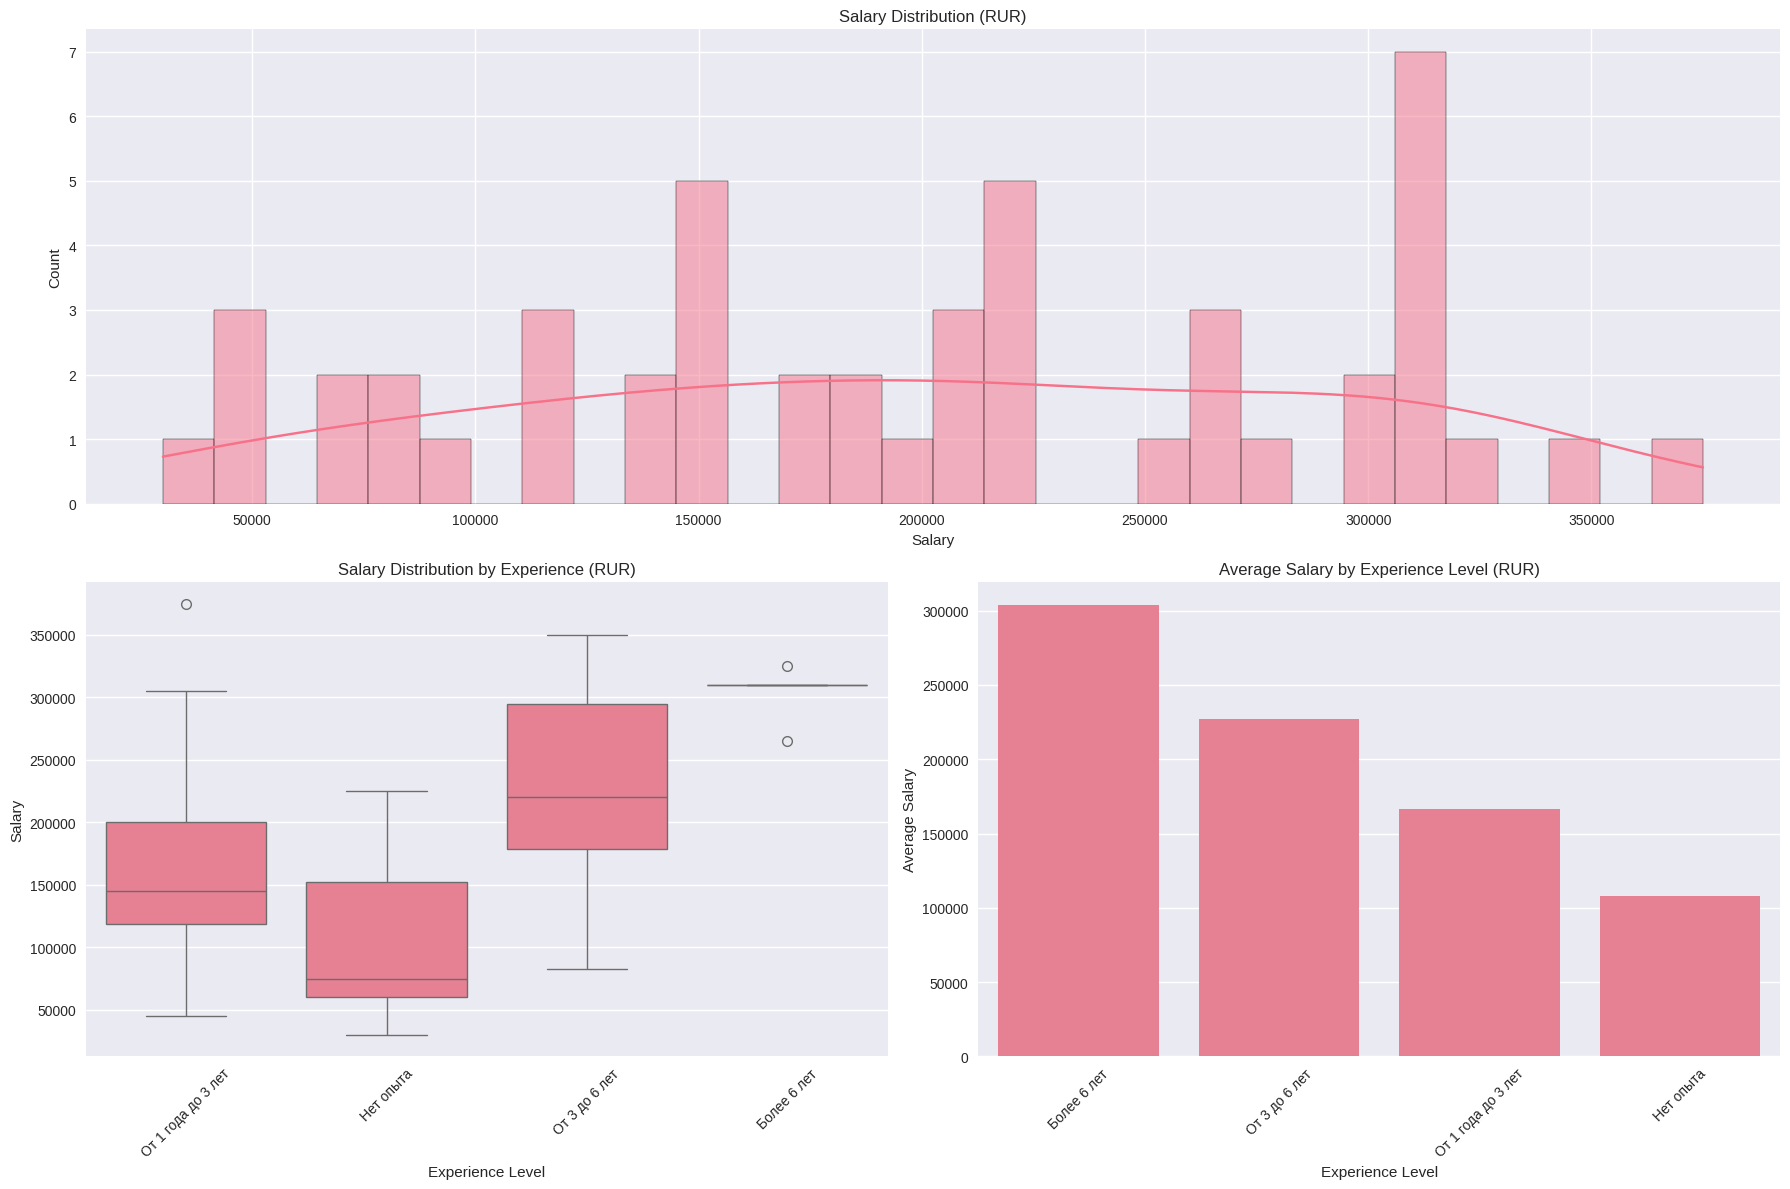


## Experience & Employment Dashboard ##


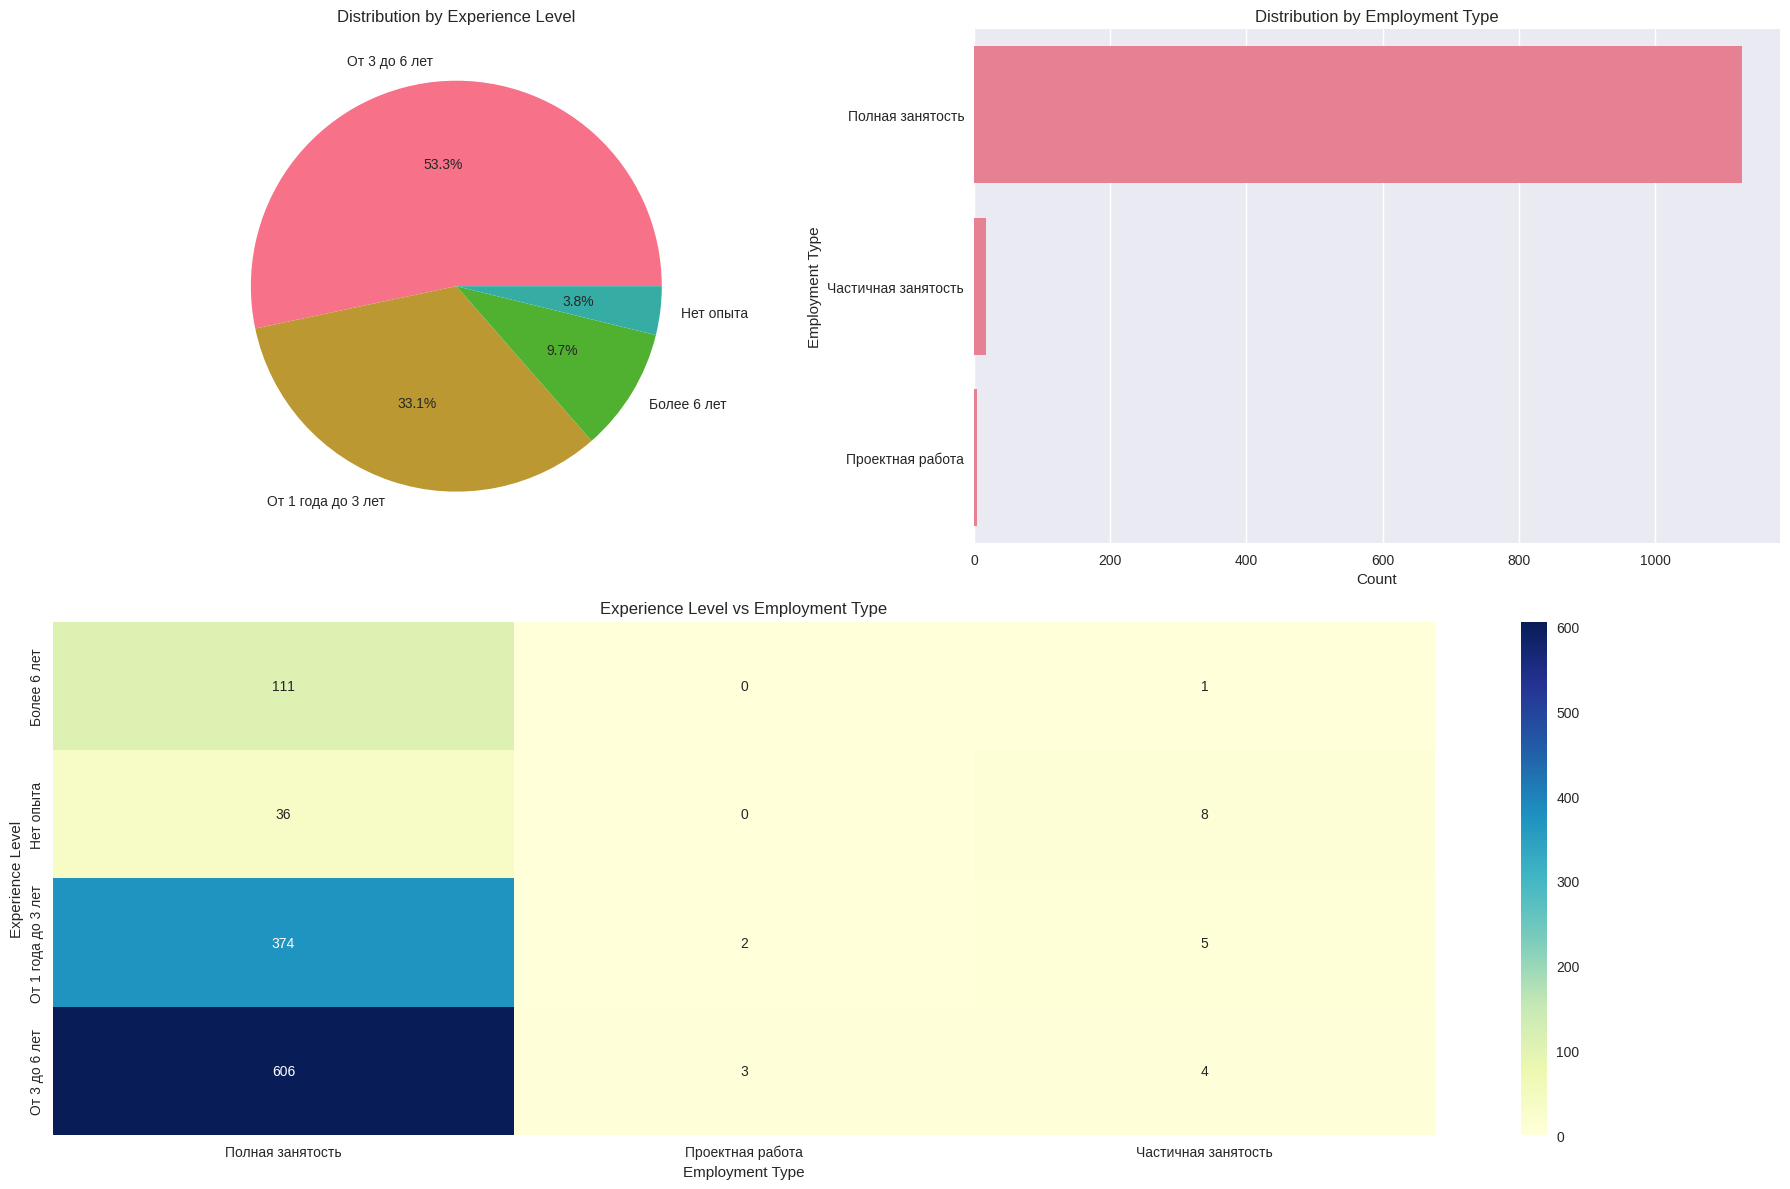

In [13]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re

# Load your data
# Replace with your actual file path
df = pd.read_csv('vacancies.csv')

# Data preprocessing
# Calculate average salary where possible
df['salary_avg'] = df.apply(lambda x: (x['salary_from'] + x['salary_to']) / 2
                           if pd.notna(x['salary_from']) and pd.notna(x['salary_to'])
                           else None, axis=1)

# Clean experience data
df['experience'] = df['experience'].fillna('Не указан')

# Clean requirements text
df['requirements_clean'] = df['requirements'].fillna('').apply(lambda x: re.sub(r'[^\w\s]', '', str(x).lower()))

# Set style for all plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Dashboard 1: Salary Analysis
def salary_dashboard(currency='RUR', experience_level='all'):
    plt.figure(figsize=(18, 12))

    # Filter data
    filtered_df = df[df['currency'] == currency]
    if experience_level != 'all':
        filtered_df = filtered_df[filtered_df['experience'] == experience_level]

    # Plot 1: Salary Distribution
    plt.subplot(2, 1, 1)
    sns.histplot(filtered_df['salary_avg'].dropna(), bins=30, kde=True)
    plt.title(f'Salary Distribution ({currency})')
    plt.xlabel('Salary')
    plt.ylabel('Count')

    # Plot 2: Salary by Experience
    plt.subplot(2, 2, 3)
    sns.boxplot(data=filtered_df, x='experience', y='salary_avg')
    plt.title(f'Salary Distribution by Experience ({currency})')
    plt.xlabel('Experience Level')
    plt.ylabel('Salary')
    plt.xticks(rotation=45)

    # Plot 3: Top Paying Experience Levels
    plt.subplot(2, 2, 4)
    exp_salary = filtered_df.groupby('experience')['salary_avg'].mean().sort_values(ascending=False)
    sns.barplot(x=exp_salary.index, y=exp_salary.values)
    plt.title(f'Average Salary by Experience Level ({currency})')
    plt.xlabel('Experience Level')
    plt.ylabel('Average Salary')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Dashboard 2: Experience & Employment
def experience_employment_dashboard():
    plt.figure(figsize=(18, 12))

    # Plot 1: Experience Distribution
    plt.subplot(2, 2, 1)
    exp_counts = df['experience'].value_counts()
    plt.pie(exp_counts, labels=exp_counts.index, autopct='%1.1f%%')
    plt.title('Distribution by Experience Level')

    # Plot 2: Employment Distribution
    plt.subplot(2, 2, 2)
    emp_counts = df['employment'].value_counts()
    sns.barplot(y=emp_counts.index, x=emp_counts.values)
    plt.title('Distribution by Employment Type')
    plt.xlabel('Count')
    plt.ylabel('Employment Type')

    # Plot 3: Experience vs Employment
    plt.subplot(2, 1, 2)
    cross_tab = pd.crosstab(df['experience'], df['employment'])
    sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('Experience Level vs Employment Type')
    plt.xlabel('Employment Type')
    plt.ylabel('Experience Level')

    plt.tight_layout()
    plt.show()

# Create interactive widgets for each dashboard
print("## Salary Analysis Dashboard ##")
salary_dashboard()

print("\n## Experience & Employment Dashboard ##")
experience_employment_dashboard()